# Intel OneAPI hackathon entry by Anushka Panda
## References
- [A tutorial on Brain tumor classification using TensorFlow](https://levelup.gitconnected.com/brain-tumor-classification-using-tensorflow-and-transfer-learning-b4b7ab5fd7cf)
- [A tutorial on oneAPI sklearn patching by Intel](https://github.com/IntelSoftware/Machine-Learning-using-oneAPI)
- [Using oneAPI and oneDNN for TensorFlow](https://www.intel.com/content/www/us/en/developer/tools/oneapi/training/machine-learning-using-oneapi.html)
## Dataset:
- https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Preprocessing

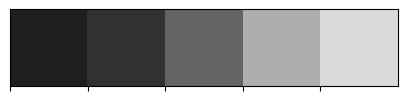

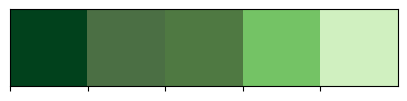

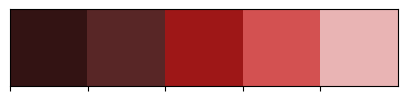

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
# imma change this later (don't want to complicate my project for no reason)

In [ ]:
!!pip install patool

['Collecting patool',
 '  Downloading patool-1.12-py2.py3-none-any.whl (77 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/77.5 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b77.5/77.5 kB\x1b \x1b2.1 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hInstalling collected packages: patool',
 'Successfully installed patool-1.12']

In [ ]:
import patoolib

In [ ]:
patoolib.extract_archive('archive.zip')

patool: Extracting archive.zip ...
patool: running /usr/bin/7z x -o./Unpack_6e3jd2_k -- archive.zip
patool: ... archive.zip extracted to `archive' (multiple files in root).


'archive'

In [7]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('./archive','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('./archive','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 143.62it/s]


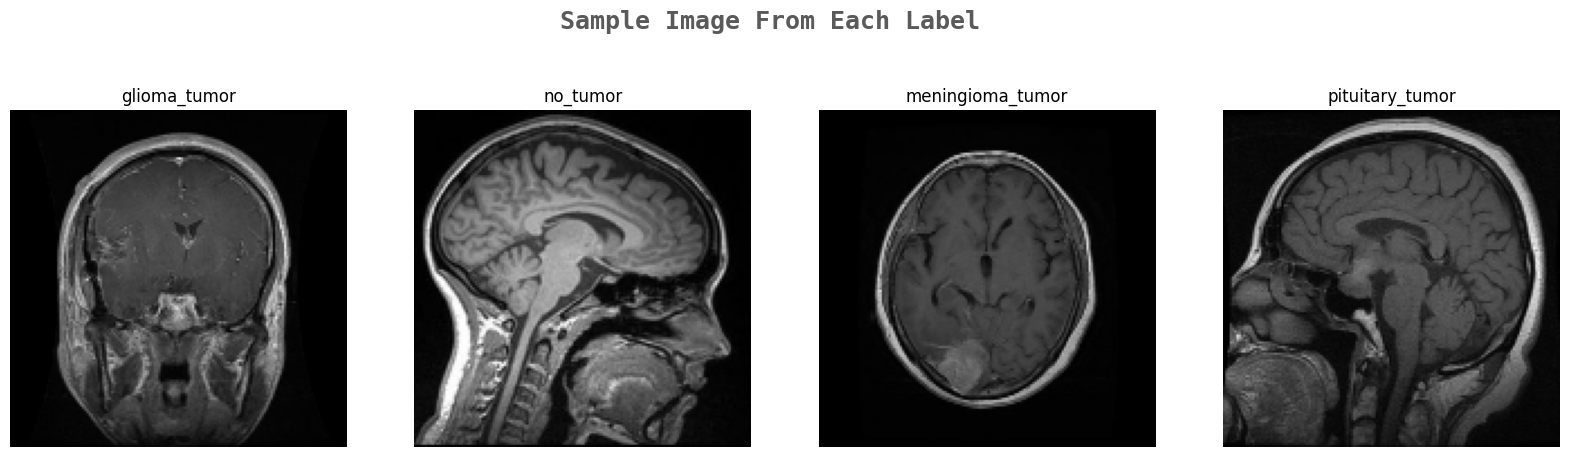

In [8]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [9]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

(3264, 150, 150, 3)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)


In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## Using SKLearn Patching

In [27]:
import time

In [28]:
params = {
    'n_neighbors': 40,
    'weights': 'distance',
    'n_jobs': -1
}

In [48]:
x_train = []
x_test = []
for x in X_train:
    new_x = x.flatten()
    x_train.append(new_x)

In [49]:
for x in X_test:
    new_x = x.flatten()
    x_test.append(new_x)

In [50]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [53]:
print(y_train.shape)

(2937, 4)


In [55]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn = KNeighborsClassifier(**params).fit(x_train, y_train)
predicted = knn.predict(x_test)
patched_time = time.time() - start_time
print("Time to calculate \033[1m knn.predict in Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))

report = classification_report(y_test, predicted)
print(f"Classification report for kNN:\n{report}\n")


Time to calculate  knn.predict in Patched scikit-learn  8.3 seconds
Classification report for kNN:
              precision    recall  f1-score   support

           0       0.67      0.82      0.73        93
           1       0.84      0.75      0.79        51
           2       0.89      0.34      0.50        96
           3       0.91      0.92      0.91        87

   micro avg       0.80      0.69      0.74       327
   macro avg       0.83      0.71      0.73       327
weighted avg       0.83      0.69      0.72       327
 samples avg       0.69      0.69      0.69       327




In [ ]:
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
start_time = time.time()
knn = KNeighborsClassifier(**params).fit(x_train, y_train)
predicted = knn.predict(x_test)
patched_time = time.time() - start_time
print("Time to calculate \033[1m knn.predict in Patched scikit-learn {:4.1f}\033[0m seconds".format(patched_time))

report = classification_report(y_test, predicted)
print(f"Classification report for kNN:\n{report}\n")

## Using Tensorflow

In [ ]:
tf.disable_v2_behavior()


'''
Environment settings:
Set ONEDNN_VERBOSE=1 to show oneDNN run time verbose
Set KMP_AFFINITY=verbose to show OpenMP thread information
'''
#import os; os.environ["ONEDNN_VERBOSE"] = "1"
#import os; os.environ["KMP_AFFINITY"] = "granularity=fine,compact,1,0"
'''
Sanity Check: once Intel-optimized TensorFlow is installed, Intel oneDNN optimizations are present by default.
'''
TODO for TF2.0
print("Intel oneDNN optimizations are present : ", tf.pywrap_tensorflow.IsMklEnabled())


In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 1s 0us/step


In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [15]:
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [18]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [26]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.2020 - accuracy: 0.9277
Epoch 1: val_accuracy did not improve from 0.86735
83/83 [==============================] - 375s 4s/step - loss: 0.2020 - accuracy: 0.9277 - val_loss: 1.2958 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9572
Epoch 2: val_accuracy improved from 0.86735 to 0.92177, saving model to effnet.h5
83/83 [==============================] - 374s 5s/step - loss: 0.1376 - accuracy: 0.9572 - val_loss: 0.2438 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9735
Epoch 3: val_accuracy improved from 0.92177 to 0.92857, saving model to effnet.h5
83/83 [==============================] - 379s 5s/step - loss: 0.0729 - accuracy: 0.9735 - val_loss: 0.3372 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.0653

In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 13s 799ms/step


In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83        93
           1       0.88      0.73      0.80        51
           2       0.86      0.75      0.80        96
           3       0.95      0.90      0.92        87

    accuracy                           0.84       327
   macro avg       0.86      0.83      0.84       327
weighted avg       0.85      0.84      0.84       327



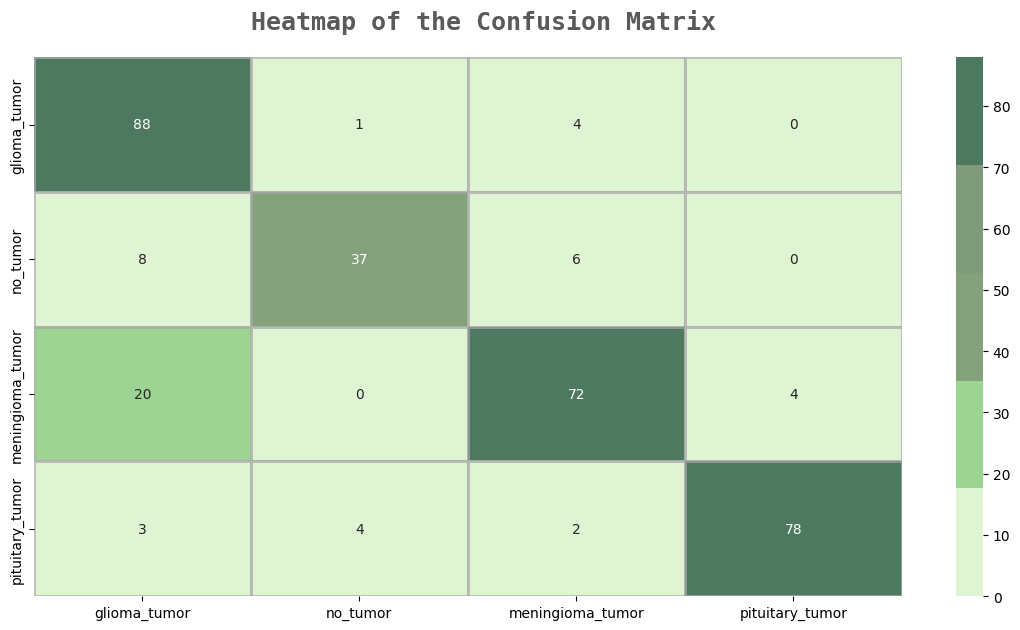

In [24]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()


In [25]:
model.save('model-oneapi.h5')
